Proszę pobrać zbiór fasion MNIST (torchvision.datasets.FashionMNIST) i zaproponować sieć konwolucyjną do jego klasyfikacji. Dla co najmniej trzech architektur proszę wypisać macierz pomyłek i wykresy funkcji strat podczas uczenia. Proszę spróbować w każdym wypadku podać przynajmniej jeden źle zaklasyfikowany obrazek.

_Proszę pamiętać, że zadanie może wymagać odpowiedniego czasu na obliczenia. Nie polecamy wykonywać go na komputerach uczelnianych, tylko wykorzystać zasoby colaba (albo własne, jeśli państwo chcą). Ewentualne przyśpieszenie obliczeń można uzyskać korzystając z GPU w colabie, jeżeli nie dysponują państwo kartą NVidii albo nie chcą jej państwo używać (opisane w zadaniu 2*)_

Running on: cuda:0


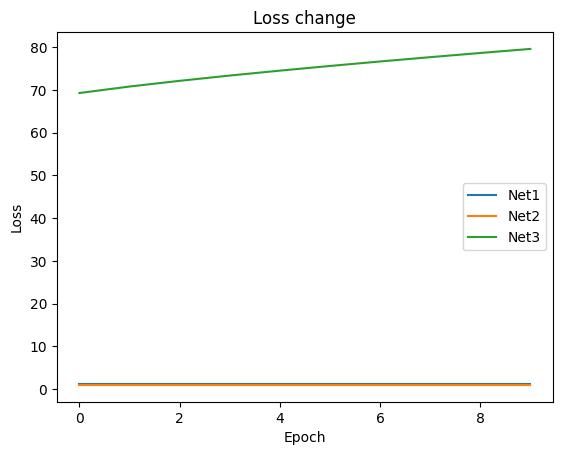

In [30]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)
class Net1(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(self._get_conv_output(input_size), 10)
    def _get_conv_output(self, shape):
        o = self.pool(F.relu(self.conv1(torch.zeros(1, *shape))))
        return int(np.prod(o.size()))
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
class Net2(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(self._get_conv_output(input_size), 120)
        self.fc2 = nn.Linear(120, 10)
    def _get_conv_output(self, shape):
        o = self.pool(F.relu(self.conv1(torch.zeros(1, *shape))))
        o = self.pool(F.relu(self.conv2(o)))
        return int(np.prod(o.size()))
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
class Net3(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(self._get_conv_output(input_size), 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def _get_conv_output(self, shape):
        o = self.pool(F.relu(self.conv1(torch.zeros(1, *shape))))
        o = self.pool(F.relu(self.conv2(o)))
        o = self.pool(F.relu(self.conv3(o)))
        return int(np.prod(o.size()))
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on:", device)
input_size = (1, 28, 28)
nets = [Net1(input_size).to(device), Net2(input_size).to(device), Net3(input_size).to(device)]
loss_function = nn.CrossEntropyLoss()
optimizers = [optim.Adam(net.parameters()) for net in nets]
losses = [[] for _ in range(len(nets))]
for epoch in range(10):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        for net, optimizer in zip(nets, optimizers):
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            running_losses[j] += loss.item()
    for j in range(len(nets)):
        losses[j].append(running_losses[j] / len(trainloader))
for i, loss in enumerate(losses):
    plt.plot(loss, label=f'Net{i+1}')
plt.title('Loss change')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Dokładność sieci: 87 %
[[854   1  20  32   7   2  66   0  18   0]
 [  0 966   2  22   6   0   2   0   2   0]
 [ 15   1 865  11  55   0  42   0  11   0]
 [ 15   6  16 909  26   0  23   0   5   0]
 [  1   1 131  41 767   0  52   0   7   0]
 [  0   0   0   1   0 969   0  25   1   4]
 [160   2 114  35  86   0 581   0  22   0]
 [  0   0   0   0   0  28   0 944   1  27]
 [  3   2   6   7   1   2   1   5 973   0]
 [  0   0   0   0   0   9   0  42   1 948]]


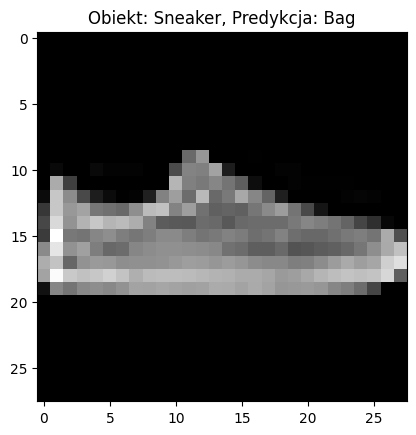

Dokładność sieci: 88 %
[[835   0  27  23   2   0 100   0  13   0]
 [  2 971   2  18   2   1   2   0   2   0]
 [ 17   2 863   8  47   0  59   0   4   0]
 [ 15   6  20 893  32   0  30   0   4   0]
 [  1   1  98  31 774   0  91   0   4   0]
 [  0   0   0   0   0 975   0  13   0  12]
 [142   1  96  31  66   0 645   0  19   0]
 [  0   0   0   0   0  26   0 941   1  32]
 [  5   1   7   6   3   3   3   5 967   0]
 [  0   0   0   0   0  12   0  37   1 950]]


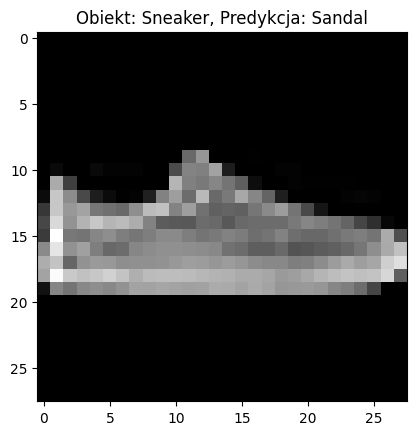

Dokładność sieci: 85 %
[[844   0  24   9   3   6  90   0  24   0]
 [  2 961   0  22   4   1   9   0   1   0]
 [ 19   0 832   6  60   0  73   0  10   0]
 [ 38   2  16 845  27   1  61   0  10   0]
 [  2   0 136  22 705   0 123   0  12   0]
 [  0   0   0   1   0 959   0  17   4  19]
 [180   2 123  13  72   0 573   0  37   0]
 [  0   0   0   0   0  31   0 892   0  77]
 [  1   0  10   2   3   8   7   2 965   2]
 [  1   0   0   0   0   6   0  21   0 972]]


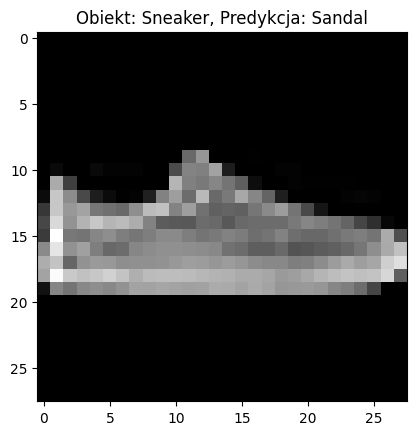

In [32]:
for net in nets:
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print('Dokładność sieci: %d %%' % (100 * correct / total))
    print(confusion_matrix(all_labels, all_preds))
    misclassified_index = next((index for index, (label, pred) in enumerate(zip(all_labels, all_preds)) if label != pred), None)
    if misclassified_index is not None:
        plt.imshow(testset[misclassified_index][0].numpy().squeeze(), cmap='gray')
        plt.title(f'Obiekt: {testset.classes[all_labels[misclassified_index]]}, Predykcja: {testset.classes[all_preds[misclassified_index]]}')
        plt.show()

In [28]:
print('Czy mam CUDA?', torch.cuda.is_available() )
x = torch.cuda.current_device() # zwraca ID urządzenia
print('Nazwa GPU x:',torch.cuda.get_device_name(x))
print('Wersja CUDNN:', torch.backends.cudnn.version())
print('Ilość urządzeń CUDA:', torch.cuda.device_count())
print('Nazwa urządzenia CUDA: ',torch.cuda.get_device_name(0))
print('Pamięć urządzenia CUDA [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

Czy mam CUDA? True
Nazwa GPU x: NVIDIA GeForce RTX 4070
Wersja CUDNN: 8801
Ilość urządzeń CUDA: 1
Nazwa urządzenia CUDA:  NVIDIA GeForce RTX 4070
Pamięć urządzenia CUDA [GB]: 12.878086144
